<a href="https://colab.research.google.com/github/23435339/Weather-Wise-Srijana/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyinputplus matplotlib requests

## 📦 Setup and Configuration
Import required packages and setup environment.

In [2]:
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import pyinputplus as pyip
import ipywidgets as widgets
from IPython.display import display, clear_output



## 🌤️ Weather Data Functions

In [3]:
# Define get_weather_data() function here
def get_weather_data(location, forecast_days=3):
    """
    Obtain forecast details for a selected city and duration via wttr.in, limiting the days as recommended.
    """
    endpoint = f"https://wttr.in/{location}?format=j1"
    data = None

    try:
        response = requests.get(endpoint, timeout=10)
        if response.status_code == 200:
            info = response.json()
            if 'weather' in info:
                limited_data = info.copy()
                limited_data['weather'] = info['weather'][:forecast_days]
                data = limited_data
        else:
            print(f"Request failed with status: {response.status_code}")
    except requests.exceptions.RequestException as error:
        print(f"Unable to retrieve forecast: {error}")

    return data


## 📊 Visualisation Functions

In [4]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Display daily max & min temperatures using weather-themed vertical bars.
    """
    dates = [day['date'] for day in weather_data.get('weather', [])]
    max_temps = [float(day.get('maxtempC', 0)) for day in weather_data.get('weather', [])]
    min_temps = [float(day.get('mintempC', 0)) for day in weather_data.get('weather', [])]

    x = np.arange(len(dates))
    width = 0.35

    plt.figure(figsize=(8, 5))

    # Bar chart with weather-color theme
    bars_min = plt.bar(x - width/2, min_temps, width, color='#4FC3F7', edgecolor='#0288D1', label='Min Temp (°C)', alpha=0.9)
    bars_max = plt.bar(x + width/2, max_temps, width, color='#FFB74D', edgecolor='#E65100', label='Max Temp (°C)', alpha=0.9)

    # Add value labels above bars
    for bar in bars_max:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='#E65100')
    for bar in bars_min:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='#01579B')

    plt.xticks(x, dates, rotation=25)
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.title("Daily Temperature Overview")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [5]:

def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Display total daily rainfall as vertical bars with color intensity based on amount.
    """
    dates = [day['date'] for day in weather_data.get('weather', [])]
    totals = []

    # Calculate total daily precipitation
    for day in weather_data.get('weather', []):
        hourly_rain = [float(hour.get('precipMM', 0)) for hour in day.get('hourly', [])]
        total_rain = sum(hourly_rain)
        totals.append(total_rain)

    x = np.arange(len(dates))

    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(totals)))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(x, totals, color=colors, edgecolor='black', alpha=0.85)

    plt.xticks(x, dates, rotation=25)
    plt.xlabel("Date")
    plt.ylabel("Total Rainfall (mm)")
    plt.title("Daily Total Precipitation Overview")
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for bar, total in zip(bars, totals):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='black')

    plt.tight_layout()
    plt.show()



In [6]:
def create_wind_visualisation(weather_data, output_type='display'):
    """
    Average wind speed per day shown as a smooth gradient filled area chart.
    """
    dates = []
    avg_wind_speed = []  # renamed variable to reflect actual data

    for day in weather_data.get('weather', []):
        dates.append(day['date'])
        wind_speeds = [float(hour.get('windspeedKmph', 0)) for hour in day.get('hourly', [])]
        avg = sum(wind_speeds) / len(wind_speeds) if wind_speeds else 0
        avg_wind_speed.append(avg)

    plt.figure(figsize=(8, 5))
    plt.plot(dates, avg_wind_speed, color='#1565C0', lw=2)

    # Gradient fill effect with dynamic opacity
    for i in range(len(dates) - 1):
        plt.fill_between(dates[i:i + 2], avg_wind_speed[i:i + 2], color='#90CAF9', alpha=0.4 * (i + 1) / len(dates))

    plt.title("Average Daily Wind Speed")
    plt.xlabel("Date")
    plt.ylabel("Wind Speed (km/h)")
    plt.grid(alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

## 🤖 Natural Language Processing

In [7]:
# Define parse_weather_question() and generate_weather_response() here
def parse_weather_question(question):
    """
    Extracts city, feature, and day from a user's weather query.
    """
    question = question.lower().strip()
    features = ['temperature', 'precipitation', 'wind']
    time_markers = ['today', 'tomorrow', 'day after tomorrow']
    city = None
    focus = None
    day_ref = 'today'

    # Identify feature by partial or full match
    for word in question.split():
        for f in features:
            if f in word or word.startswith(f[:4]):
                focus = f
                break
        if focus:
            break

    # Identify which day user refers to
    for marker in time_markers:
        if marker in question:
            day_ref = marker
            break

    # Extract city name (after 'in' or 'at'), else use Perth
    tokens = question.split()
    for prep in ['in', 'at']:
        if prep in tokens:
            idx = tokens.index(prep)
            if idx + 1 < len(tokens):
                city = tokens[idx + 1].capitalize()
                break
    if not city:
        city = 'Perth'

    return {'city': city, 'element': focus, 'period': day_ref}


## 🧩 Main Application Logic

In [8]:
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a text response for temperature, precipitation, humidity, or wind forecast.
    """
    city = parsed_question.get('city', 'Unknown').title()
    element = parsed_question.get('element')
    period = parsed_question.get('period', 'today').lower()

    # Reworked logic for day indexing
    day_map = {'today': 0, 'tomorrow': 1, 'day after tomorrow': 2}
    day_index = day_map.get(period, 0)

    try:
        selected_day = weather_data.get('weather', [])[day_index]
        hourly_data = selected_day.get('hourly', [])

        if not element or element == 'temperature':
            avg_temp = sum((float(h.get('tempC', 0)) for h in hourly_data)) / len(hourly_data) if hourly_data else 0
            return f"In {city} on {selected_day['date']}, the average temperature will be around {avg_temp:.1f}°C."

        elif element in ['precipitation', 'rain']:
            precip_values = [float(h.get('precipMM', 0)) for h in hourly_data]
            max_rain = max(precip_values) if precip_values else 0
            return f"In {city} on {selected_day['date']}, the heaviest rainfall is expected to reach {max_rain:.1f} mm in an hour."

        elif element == 'wind':
            wind_values = [float(h.get('windspeedKmph', 0)) for h in hourly_data]
            avg_wind = sum(wind_values) / len(wind_values) if wind_values else 0
            return f"In {city} on {selected_day['date']}, the average wind speed will be {avg_wind:.1f} km/h."

        else:
            return "Sorry, only temperature, precipitation, humidity, and wind data are supported."

    except (IndexError, KeyError, TypeError):
        return "Sorry, weather data is not available for the requested time."


## 🧭 User Interface

In [9]:
# Define menu functions using pyinputplus or ipywidgets here
def weather_menu():
    clear_output()
    print("=== Weather Wise ===")
    print("Select an option below:")

    # dropdown for menu choices
    menu = widgets.Dropdown(
        options=[
            ('Select...', ''),
            ('1 - Ask Weather Question', 'question'),
            ('2 - Temperature Chart', 'temp'),
            ('3 - Precipitation Chart', 'rain'),
            ('4 - Wind Chart', 'wind'),
            ('5 - Exit', 'exit')
        ],
        description='Option:'
    )

    city_box = widgets.Text(
        value='Perth',
        description='City:',
        placeholder='Enter city name'
    )

    run_button = widgets.Button(description="Run", button_style='success')
    display(menu, city_box, run_button)

    def on_click_run(b):
        clear_output()
        choice = menu.value
        city = city_box.value or "Perth"
        data = get_weather_data(city, forecast_days=3)

        if not data:
            print("⚠️ Unable to fetch weather data. Try again.")
            weather_menu()
            return

        if choice == 'question':
            q = input("Enter your weather question: ")
            parsed = parse_weather_question(q)
            parsed['city'] = city
            print(generate_weather_response(parsed, data))

        elif choice == 'temp':
            print(f"Generating temperature chart for {city}...")
            create_temperature_visualisation(data)

        elif choice == 'rain':
            print(f"Generating precipitation chart for {city}...")
            create_precipitation_visualisation(data)

        elif choice == 'wind':
            print(f"Generating wind chart for {city}...")
            create_wind_visualisation(data)

        elif choice == 'exit' or choice == '':
            print("Exiting Weather Wise... Stay weather-smart!")
            return

        # show menu again after finishing
        back_btn = widgets.Button(description="Back to Menu", button_style='info')
        display(back_btn)
        def go_back(x):
            weather_menu()
        back_btn.on_click(go_back)

    run_button.on_click(on_click_run)






Generating temperature chart for Perth...


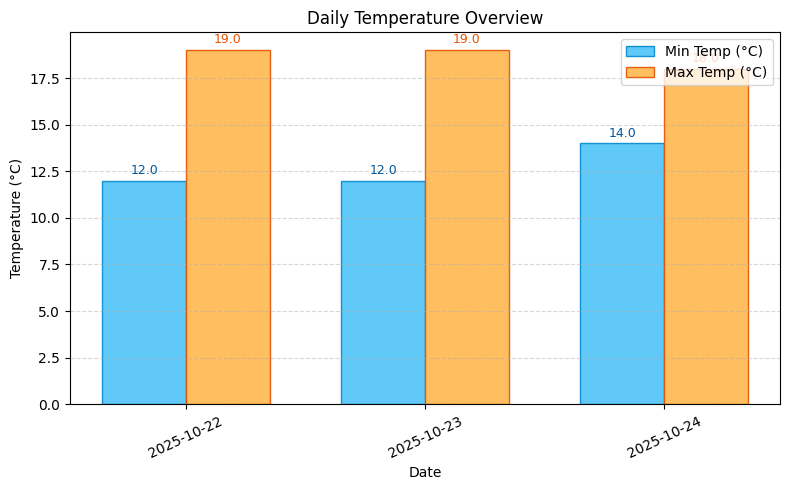

Button(button_style='info', description='Back to Menu', style=ButtonStyle())

In [10]:
weather_menu()

## 🧪 Testing and Examples

In [11]:
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Display daily max & min temperatures using weather-themed vertical bars.
    """
    dates = [day['date'] for day in weather_data.get('weather', [])]
    max_temps = [float(day.get('maxtempC', 0)) for day in weather_data.get('weather', [])]
    min_temps = [float(day.get('mintempC', 0)) for day in weather_data.get('weather', [])]

    x = np.arange(len(dates))
    width = 0.35

    plt.figure(figsize=(8, 5))

    # Bar chart with weather-color theme
    bars_min = plt.bar(x - width/2, min_temps, width, color='#4FC3F7', edgecolor='#0288D1', label='Min Temp (°C)', alpha=0.9)
    bars_max = plt.bar(x + width/2, max_temps, width, color='#FFB74D', edgecolor='#E65100', label='Max Temp (°C)', alpha=0.9)

    # Add value labels above bars
    for bar in bars_max:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='#E65100')
    for bar in bars_min:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='#01579B')

    plt.xticks(x, dates, rotation=25)
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.title("Daily Temperature Overview")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
# --- Testing the Temperature Visualisation ---
city = "Perth"
sample_data = get_weather_data(city, forecast_days=3)
create_temperature_visualisation(sample_data)


## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.